In [1]:
import torch
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

In [2]:
device = 'cpu'
df_org = pd.read_csv("./fixed_data.csv")[:500]
df_org = df_org.sample(frac=1, random_state=42)
df_org.head()

,link,headline,category,short_description,authors,date,cleaned_text
361,https://www.huffpost.com/entry/christian-natio...,Christian Nationalism On The Rise In Some GOP ...,POLITICS,Doug Mastriano’s win in the Pennsylvania guber...,"PETER SMITH and DEEPA BHARATH, AP NEWS",1653782400000,doug mastriano win pennsylvania gubernatorial ...
73,https://www.huffpost.com/entry/truth-social-do...,Donald Trump's Truth Social Reportedly Faces M...,POLITICS,A major vendor claims it was stiffed by Trump'...,Mary Papenfuss,1661472000000,major vendor claim stiffed trump social medium...
374,https://www.huffpost.com/entry/greg-abbott-res...,Texas Gov. On State's Deadliest School Shootin...,POLITICS,"GOP Gov. Greg Abbott said what Texans need ""no...",Nina Golgowski,1653436800000,gop gov greg abbott said texan need ever love ...
155,https://www.huffpost.com/entry/kenan-thompson-...,Kenan Thompson: Ending 'SNL' After 50th Season...,ENTERTAINMENT,The longest-running cast member said Lorne Mic...,David Moye,1659052800000,cast member said lorne michael rumored departu...
104,https://www.huffpost.com/entry/denver-broncos-...,The Denver Broncos’ Historic Purchase Could In...,SPORTS,Broncos quarterback Russell Wilson said the ne...,Andre Ellington,1660608000000,bronco quarterback russell wilson said new own...


In [3]:
labels = df_org['category'].unique().tolist()
NUM_LABELS = len(labels)
labels

['POLITICS',
 'ENTERTAINMENT',
 'SPORTS',
 'HOME & LIVING',
 'WELLNESS',
 'COMEDY',
 'BUSINESS',
 'PARENTING',
 'FOOD & DRINK',
 'STYLE & BEAUTY',
 'QUEER VOICES',
 'BLACK VOICES']

In [4]:
labels2id = {label:i for i,label in enumerate(labels) }
id2labels = {i:label for i,label in enumerate(labels) }
print(labels2id)
print(id2labels)


{'POLITICS': 0, 'ENTERTAINMENT': 1, 'SPORTS': 2, 'HOME & LIVING': 3, 'WELLNESS': 4, 'COMEDY': 5, 'BUSINESS': 6, 'PARENTING': 7, 'FOOD & DRINK': 8, 'STYLE & BEAUTY': 9, 'QUEER VOICES': 10, 'BLACK VOICES': 11}
{0: 'POLITICS', 1: 'ENTERTAINMENT', 2: 'SPORTS', 3: 'HOME & LIVING', 4: 'WELLNESS', 5: 'COMEDY', 6: 'BUSINESS', 7: 'PARENTING', 8: 'FOOD & DRINK', 9: 'STYLE & BEAUTY', 10: 'QUEER VOICES', 11: 'BLACK VOICES'}


In [5]:
df_org['labels'] = df_org['category'].apply(lambda x: labels2id[x])

df_org = df_org[['category', 'labels','short_description']]
df_org = df_org.dropna()
df_org.head()

,category,labels,short_description
361,POLITICS,0,Doug Mastriano’s win in the Pennsylvania guber...
73,POLITICS,0,A major vendor claims it was stiffed by Trump'...
374,POLITICS,0,"GOP Gov. Greg Abbott said what Texans need ""no..."
155,ENTERTAINMENT,1,The longest-running cast member said Lorne Mic...
104,SPORTS,2,Broncos quarterback Russell Wilson said the ne...


<Axes: ylabel='count'>

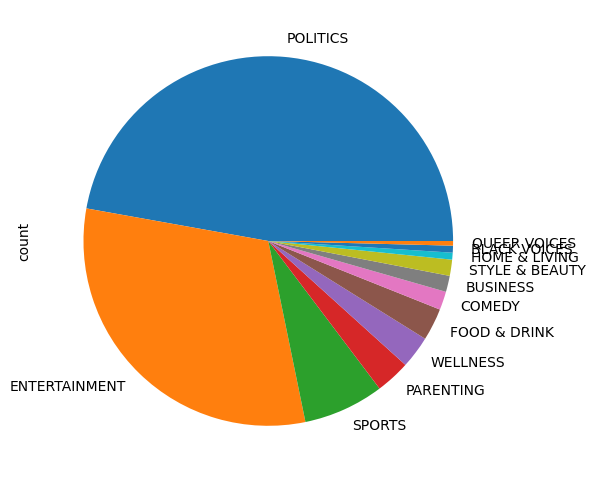

In [6]:
df_org['category'].value_counts().plot(kind='pie', figsize=(6, 6))

In [7]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True, max_len=256)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_LABELS, id2label=id2labels, label2id=labels2id)
model.to(device)
print("done")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


done


In [8]:
SIZE = df_org.shape[0]

# df_org.head()
str_short_description = [str(s) for s in df_org['short_description']]
str_labels = [(s) for s in df_org['labels']]


train_texts = list(str_short_description[:SIZE//2])

val_texts = list(str_short_description[:SIZE//2:(3*SIZE)//4])
test_texts = list(str_short_description[(3*SIZE)//4:])


train_labels = list(str_labels[:SIZE//2])
val_labels = list(str_labels[:SIZE//2:(3*SIZE)//4])
test_labels = list(str_labels[(3*SIZE)//4:])




train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)



In [9]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)
    

In [10]:
train_dataloader = DataLoader(train_encodings, train_labels)
val_dataloader = DataLoader(val_encodings, val_labels)
test_dataloader = DataLoader(test_encodings, test_labels)

In [11]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds =  pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy':acc,
        'F1': f1,
        'Precision': precision,
        'Recall':recall
    }


In [12]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    do_train=True,
    do_eval=True,
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_strategy='steps',
    logging_dir='./logs',            # directory for storing logs
    logging_steps=50,
    evaluation_strategy='steps',
    eval_steps=50,
    save_strategy='steps',
    load_best_model_at_end=True,
)

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics = compute_metrics
)

In [14]:
trainer.train()

  0%|          | 0/93 [00:00<?, ?it/s]

{'loss': 2.1986, 'learning_rate': 2.5e-05, 'epoch': 1.61}


  0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 0.5413797497749329, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 0.0585, 'eval_samples_per_second': 17.101, 'eval_steps_per_second': 17.101, 'epoch': 1.61}
{'train_runtime': 856.5542, 'train_samples_per_second': 0.869, 'train_steps_per_second': 0.109, 'train_loss': 1.6531851163474462, 'epoch': 3.0}


TrainOutput(global_step=93, training_loss=1.6531851163474462, metrics={'train_runtime': 856.5542, 'train_samples_per_second': 0.869, 'train_steps_per_second': 0.109, 'train_loss': 1.6531851163474462, 'epoch': 3.0})

In [15]:
q = [trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataloader]]
pd.DataFrame(q, index=['train', 'val', 'test']).iloc[:,:5]

  0%|          | 0/31 [00:00<?, ?it/s]

/home/drevo/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

/home/drevo/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.526888,0.846774,0.221674,0.211343,0.234252
val,0.045323,1.000000,1.000000,1.000000,1.000000
test,0.962699,0.717742,0.213885,0.219218,0.220793


In [16]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [18]:
def predict(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
    outputs = model(**inputs)
    probs = outputs[0].softmax(dim=1)
    pred_label_idx = probs.argmax()

    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [17]:
trainer.save_model("model500")
tokenizer.save_pretrained("model500")

('model500/tokenizer_config.json',
 'model500/special_tokens_map.json',
 'model500/vocab.txt',
 'model500/added_tokens.json',
 'model500/tokenizer.json')

In [27]:
model_path = "model500"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer=BertTokenizerFast.from_pretrained(model_path)
nlp=pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


print("predicted: ")
print(nlp(df_org['short_description'][22]))
print(f"Actual: {df_org['category'][22]}")

predicted: 
[{'label': 'SPORTS', 'score': 0.2719479203224182}]
Actual: SPORTS
